In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2024-12-13 09:24:14.009221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 09:24:14.009286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 09:24:14.034806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 09:24:14.089675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 09:24:14.893047: W tensorflow/compiler/tf2

In [3]:
df = pd.read_csv(os.path.join('data','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [6]:
# Sort DataFrame by date
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


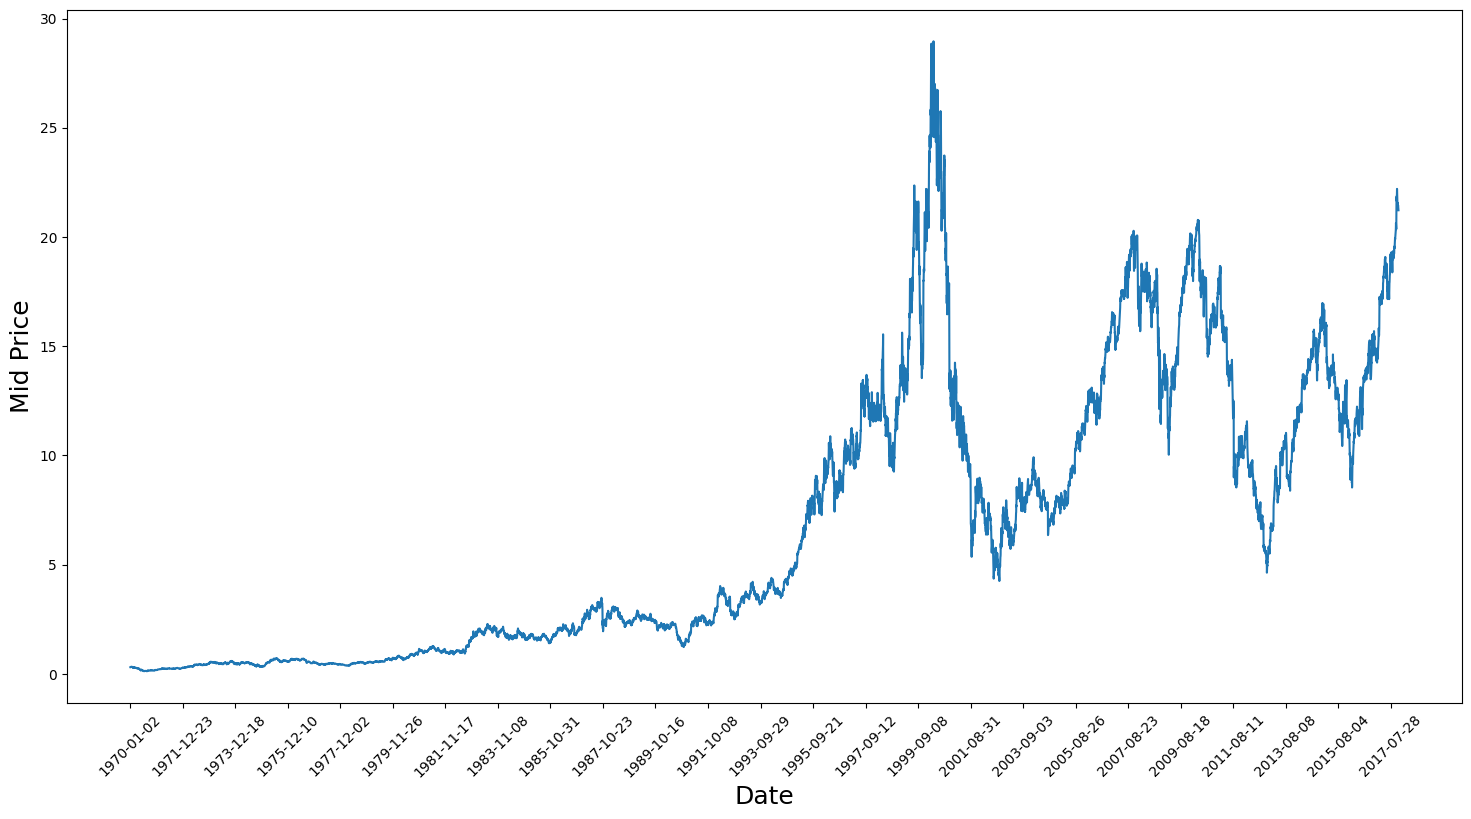

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [11]:
high_prices = df.loc[:,'High'].to_numpy()
high_prices

array([ 0.30627,  0.31768,  0.31385, ..., 21.47   , 21.4    , 21.31   ])

In [13]:
low_prices = df.loc[:,'Low'].to_numpy()
low_prices

array([ 0.30627,  0.30627,  0.30996, ..., 21.24   , 21.15   , 21.14   ])

In [14]:
mid_prices = (high_prices+low_prices)/2.0
mid_prices

array([ 0.30627 ,  0.311975,  0.311905, ..., 21.355   , 21.275   ,
       21.225   ])

In [16]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [18]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [19]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [20]:
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [21]:
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [22]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


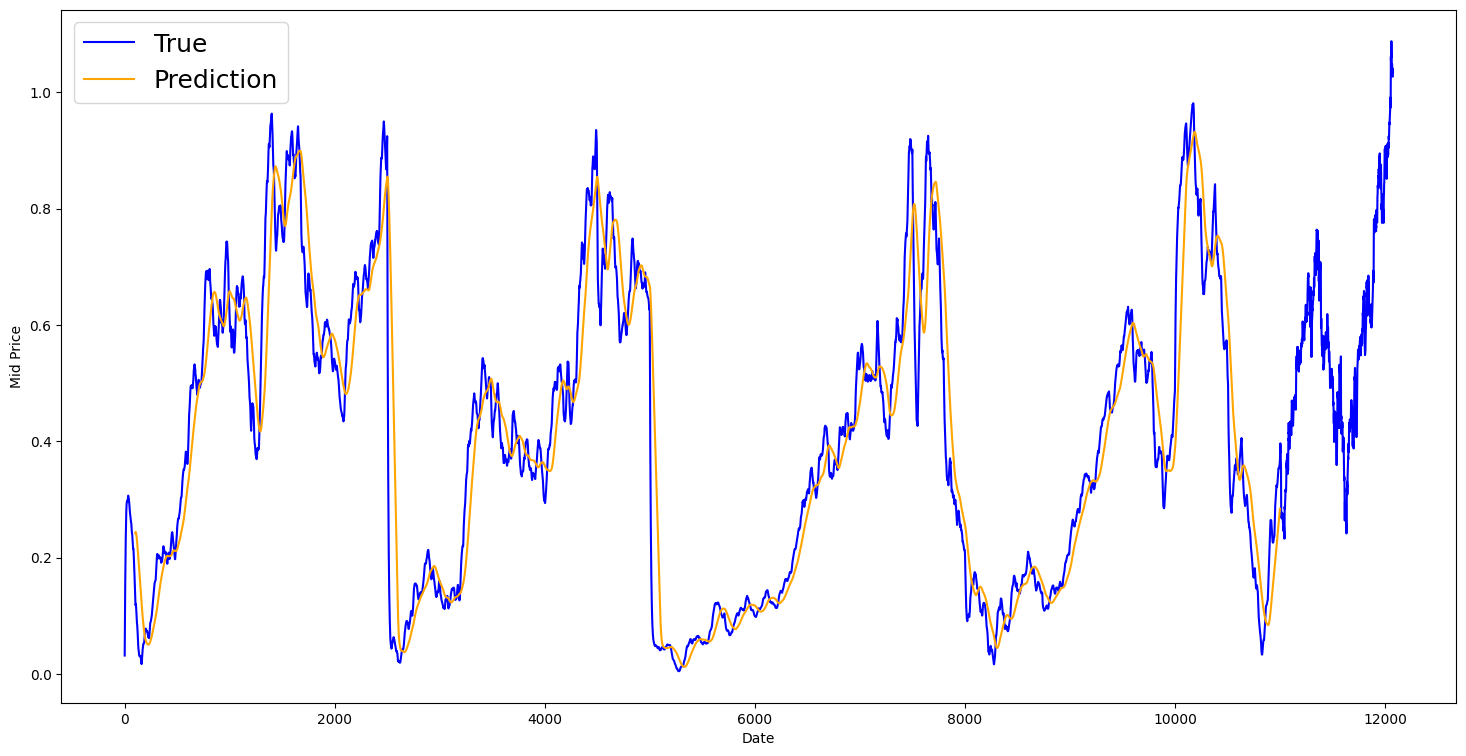

In [27]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [24]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00003


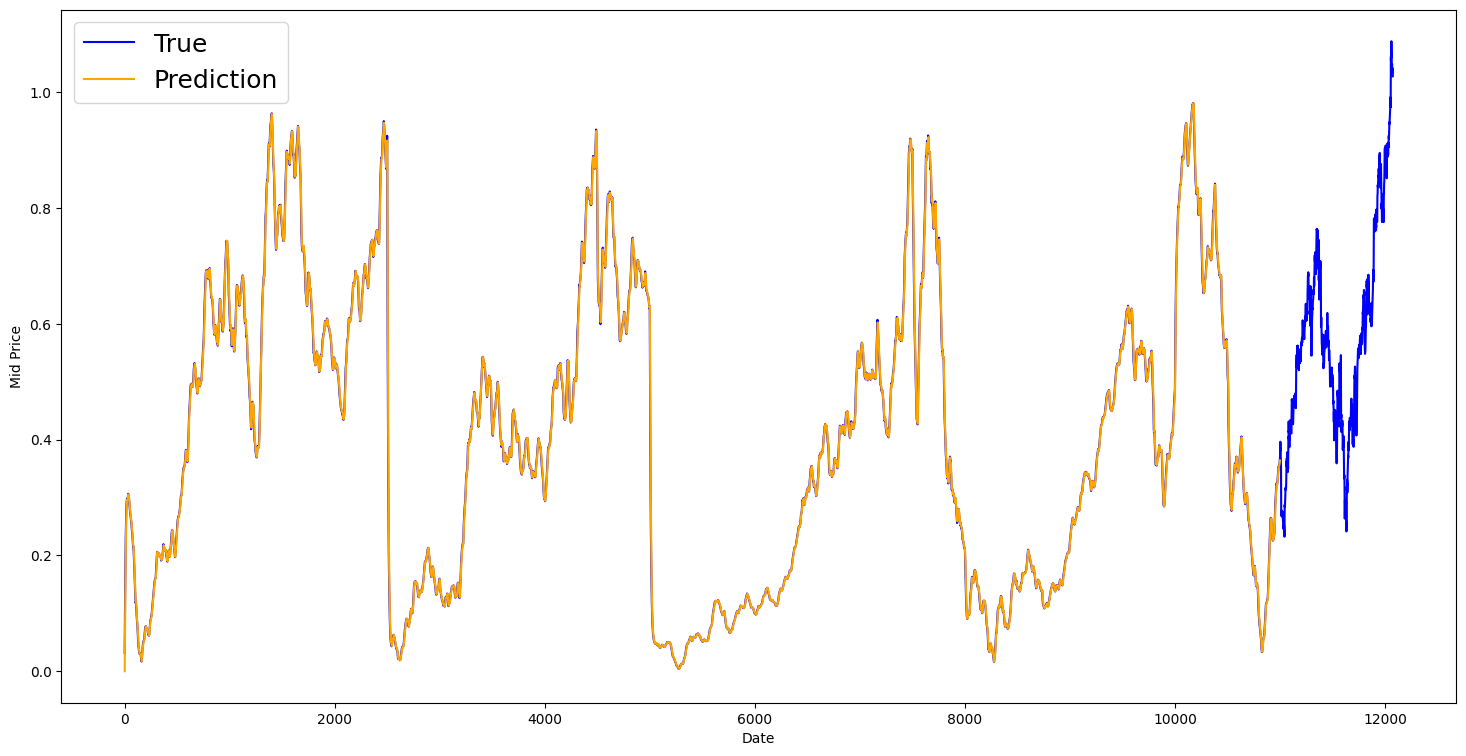

In [28]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [29]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.132895   0.6904868  0.833369   0.33219692 0.12158521]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.15261841 0.6858036  0.8325337  0.32857886 0.12192084]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.08698314 0.6826334  0.83387965 0.33650374 0.11946969]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.17132245 0.6836884  0.83420646 0.33219692 0.12106793]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.15261841 0.6820074  0.83420646 0.34456673 0.12230608]


In [31]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.keras.backend.clear_session()

In [35]:
# Input data placeholders
train_inputs = []
train_outputs = []

# Simulate dummy data for demonstration (you can replace this with your actual data)
for ui in range(num_unrollings):
    train_inputs.append(tf.zeros([batch_size, D], dtype=tf.float32, name=f'train_inputs_{ui}'))  # Example with zeros
    train_outputs.append(tf.zeros([batch_size, 1], dtype=tf.float32, name=f'train_outputs_{ui}'))

# Print shapes to verify
print(f"Number of inputs: {len(train_inputs)}")
print(f"Input shape: {train_inputs[0].shape}")
print(f"Output shape: {train_outputs[0].shape}")

Number of inputs: 50
Input shape: (500, 1)
Output shape: (500, 1)


2024-12-13 09:46:06.287738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 09:46:06.388728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 09:46:06.388946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [42]:
# Define LSTM cells with dropout
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li], dropout=dropout)
    for li in range(n_layers)
]

# Combine LSTM cells into a stacked RNN
stacked_lstm = tf.keras.layers.StackedRNNCells(lstm_cells)

# Initial state for each LSTM layer (TensorFlow 2.x handles it automatically)
initial_state = [tf.zeros((batch_size, num_nodes[li])) for li in range(n_layers)]

# Placeholder-like input (TensorFlow 2.x uses eager execution)
train_inputs = tf.random.normal([num_unrollings, batch_size, 1])  # Simulated input data

# Dynamic RNN using tf.keras.layers.RNN
rnn_layer = tf.keras.layers.RNN(stacked_lstm, return_sequences=True, return_state=True)
all_lstm_outputs, *final_state = rnn_layer(train_inputs)

# Flatten outputs for dense layer
all_lstm_outputs_flat = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])

# Define weights and biases
initializer = tf.keras.initializers.GlorotUniform()
w = tf.Variable(initializer(shape=[num_nodes[-1], 1]), name='w')
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name='b')

# Compute final outputs
all_outputs = tf.matmul(all_lstm_outputs_flat, w) + b

# Split outputs into sequences
split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

print("RNN with TensorFlow 2.x setup complete!")

RNN with TensorFlow 2.x setup complete!


In [44]:
# Define a simple model for demonstration
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=True, input_shape=(num_unrollings, 1)),
    tf.keras.layers.Dense(1)
])

# Learning rate schedule
global_step = tf.Variable(0, trainable=False)
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1,
    decay_rate=0.5,
    staircase=True
)
learning_rate = tf.maximum(learning_rate_schedule(global_step), 0.0001)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Dummy inputs and outputs for demonstration
train_inputs = tf.random.normal([batch_size, num_unrollings, 1])
train_outputs = tf.random.normal([batch_size, num_unrollings, 1])

# Training step
with tf.GradientTape() as tape:
    predictions = model(train_inputs, training=True)
    loss = tf.reduce_mean(0.5 * (predictions - train_outputs) ** 2)

# Compute gradients
gradients = tape.gradient(loss, model.trainable_variables)

# Check for None gradients
for i, grad in enumerate(gradients):
    if grad is None:
        print(f"Gradient {i} is None for variable {model.trainable_variables[i]}")

# Clip gradients and apply
gradients = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else tf.zeros_like(var)
             for grad, var in zip(gradients, model.trainable_variables)]
optimizer.apply_gradients(zip(gradients, model.trainable_variables))

print("Training step complete.")

2024-12-13 09:53:45.029124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-13 09:53:45.602184: I external/local_xla/xla/service/service.cc:168] XLA service 0x60e3e9d1fce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-13 09:53:45.602207: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-13 09:53:45.611179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734080025.691599   11570 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training step complete.


In [46]:
print('Defining prediction-related TensorFlow functions')

# Simulate a single input for prediction
sample_inputs = tf.random.normal([1, D])

# Create an LSTM model
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li])
    for li in range(n_layers)
]
multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

# Maintaining LSTM state for prediction
sample_state = [tf.zeros([1, num_nodes[li]]) for li in range(n_layers)]

# Reset sample states
def reset_sample_states():
    return [tf.zeros([1, num_nodes[li]]) for li in range(n_layers)]

# Perform prediction
rnn_layer = tf.keras.layers.RNN(multi_cell, return_state=True)
sample_outputs, *new_sample_state = rnn_layer(tf.expand_dims(sample_inputs, 0))

# Prediction
sample_prediction = tf.matmul(tf.reshape(sample_outputs, [1, -1]), w) + b

print('\tAll done')


Defining prediction-related TensorFlow functions
	All done


In [48]:
import numpy as np

# Define your LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=True, input_shape=(num_unrollings, 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.5,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer, loss='mse')

# Training loop
epochs = 30
train_mse_ot = []  # Train losses
test_mse_ot = []  # Test losses
predictions_over_time = []  # Store predictions

for ep in range(epochs):
    # Generate training data
    data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)
    train_loss = 0

    for step in range(train_seq_length // batch_size):
        u_data, u_labels = data_gen.unroll_batches()
        u_data = np.array(u_data).reshape(batch_size, num_unrollings, 1)
        u_labels = np.array(u_labels).reshape(batch_size, num_unrollings, 1)

        # Train the model
        loss = model.train_on_batch(u_data, u_labels)
        train_loss += loss

    train_mse_ot.append(train_loss / (train_seq_length // batch_size))
    print(f"Epoch {ep + 1}/{epochs}, Train Loss: {train_mse_ot[-1]}")

    # Validation step
    test_loss = 0
    predictions_seq = []
    for w_i in test_points_seq:
        current_price = all_mid_data[w_i - 1]
        input_seq = np.array(current_price).reshape(1, num_unrollings, 1)

        # Generate predictions
        our_predictions = []
        for pred_i in range(n_predict_once):
            pred = model.predict(input_seq)
            our_predictions.append(pred[0, 0])
            input_seq = np.roll(input_seq, -1, axis=1)  # Shift window
            input_seq[:, -1, :] = pred

        predictions_seq.append(our_predictions)
        test_loss += np.mean((np.array(our_predictions) - all_mid_data[w_i:w_i + n_predict_once]) ** 2)

    test_mse_ot.append(test_loss / len(test_points_seq))
    predictions_over_time.append(predictions_seq)

    print(f"Epoch {ep + 1}/{epochs}, Test Loss: {test_mse_ot[-1]}")

print("Training Complete!")


: 